In [1]:
from transformers import AutoModelForCausalLM,AutoTokenizer

raw_model_path = "/home/ubuntu/data/exp/proj2410/model/Qwen2.5-0.5B"
device = "cuda"
tokenizer = AutoTokenizer.from_pretrained(raw_model_path)
model = AutoModelForCausalLM.from_pretrained(raw_model_path,
    ).to(device)



/home/ubuntu/miniconda3/envs/quant/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model.model.layers[0].self_attn.q_proj.bias.max()

tensor(47.7500, device='cuda:0', grad_fn=<MaxBackward1>)

In [1]:
from transformers import AutoModelForCausalLM,AutoTokenizer

raw_model_path = "/home/ubuntu/data/exp/proj2410/model/Qwen2.5-0.5B"
device = "cuda"
tokenizer = AutoTokenizer.from_pretrained(raw_model_path)
model = AutoModelForCausalLM.from_pretrained(raw_model_path,
    ).to(device)

inputs = tokenizer("According to the report, the company has a good", return_tensors="pt").to(device)
outputs = model(**inputs)


/home/ubuntu/miniconda3/envs/quant/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [2]:


def get_max_logits_ids(outputs):
    max_logits, max_ids = outputs.logits.max(dim=-1)
    return max_ids

inputs.input_ids,outputs.logits.shape,get_max_logits_ids(outputs)

(tensor([[11190,   311,   279,  1895,    11,   279,  2813,   702,   264,  1661]],
        device='cuda:0'),
 torch.Size([1, 10, 151936]),
 tensor([[  311,   279,   364,   315,   279,  1372,   594,   220,  2790, 17011]],
        device='cuda:0'))

In [5]:

quant_model_path = "/home/ubuntu/data/exp/proj2410/quant_model/Qwen-2.5-0.5B/EfficientQAT/w2gs128"
from EfficientQAT.quantize.int_linear_real import load_quantized_model,QuantLinear
def get_model_and_tokenizer(_model_path:str) :
    quantized = "w" in _model_path
    if "w" in _model_path:
        wbits =2
        group_size = 128
        model,tokenizer = load_quantized_model(_model_path,
                                                    wbits=wbits,
                                                    group_size=group_size)
    else:
        model = AutoModelForCausalLM.from_pretrained(_model_path)
        tokenizer = AutoTokenizer.from_pretrained(_model_path)
    return model,tokenizer,quantized
quant_model,_,_ = get_model_and_tokenizer(quant_model_path)
quant_model.to("cuda")
quant_output = quant_model(**inputs)

Loading quantized model from /home/ubuntu/data/exp/proj2410/quant_model/Qwen-2.5-0.5B/EfficientQAT/w2gs128


100%|██████████| 24/24 [00:00<00:00, 324.01it/s]


Loading pre-computed quantized weights...
Loading pre-computed quantized weights Successfully


In [8]:
inputs.input_ids[:,1:],get_max_logits_ids(outputs),get_max_logits_ids(quant_output)

(tensor([[ 311,  279, 1895,   11,  279, 2813,  702,  264, 1661]],
        device='cuda:0'),
 tensor([[  311,   279,   364,   315,   279,  1372,   594,   220,  2790, 17011]],
        device='cuda:0'),
 tensor([[  279,   279,  2701,    11,   279,  1372,   702,   264,  2790, 17011]],
        device='cuda:0'))

In [11]:
model.generate(**inputs, max_new_tokens=20),quant_model.generate(**inputs, max_new_tokens=20)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


(tensor([[11190,   311,   279,  1895,    11,   279,  2813,   702,   264,  1661,
          17011,   323,   264,  1661,  2168,    11,   323,   279,  2813,   594,
          17011,   323,  2168,   525,   279, 16266,   369,   279,  2813,   594]],
        device='cuda:0'),
 tensor([[11190,   311,   279,  1895,    11,   279,  2813,   702,   264,  1661,
          17011,   304,   279,  4958,   323,   702,   264,  1661, 17011,   304,
            279,  3081,    13,   576,  2813,   702,   264,  1661, 17011,   304]],
        device='cuda:0'))

In [ ]:
index 63 loss 0.005315773654729128
index 63 loss 0.005365696270018816

In [1]:
import torch

for i in range(64):
    p0 = f"/home/ubuntu/data/exp/proj2410/test/cache/0_weight_{i}"
    p1 = f"/home/ubuntu/data/exp/proj2410/test/cache/1_weight_{i}"
    w0 = torch.load(p0,weights_only=True,map_location='cuda:1')
    w1 = torch.load(p1,weights_only=True,map_location='cuda:1')
    # w0 = w0
    # w1 = w1
    p_sum = (w0-w1).abs().sum()
    p_max = (w0-w1).abs().max()
    p_num = ((w0-w1) != 0).sum()
    print(f"iteration {i}: {p_sum} {p_max} {p_num}")

    # 1.0 = 1.0? 

iteration 0: 0.0 0.0 0
iteration 1: 0.0 0.0 0
iteration 2: 0.0 0.0 0
iteration 3: 0.0 0.0 0
iteration 4: 0.0 0.0 0
iteration 5: 0.0 0.0 0
iteration 6: 0.0 0.0 0
iteration 7: 0.0 0.0 0
iteration 8: 0.0 0.0 0
iteration 9: 0.0 0.0 0
iteration 10: 0.0 0.0 0
iteration 11: 0.0 0.0 0
iteration 12: 0.0 0.0 0
iteration 13: 0.0 0.0 0
iteration 14: 0.0 0.0 0
iteration 15: 0.0 0.0 0
iteration 16: 0.0 0.0 0
iteration 17: 0.0 0.0 0
iteration 18: 0.0 0.0 0
iteration 19: 0.0 0.0 0
iteration 20: 0.0 0.0 0
iteration 21: 0.0 0.0 0
iteration 22: 0.0 0.0 0
iteration 23: 0.0 0.0 0
iteration 24: 0.0 0.0 0
iteration 25: 0.0 0.0 0
iteration 26: 0.0 0.0 0
iteration 27: 0.0 0.0 0
iteration 28: 0.0 0.0 0
iteration 29: 0.0 0.0 0
iteration 30: 0.0 0.0 0
iteration 31: 0.0 0.0 0
iteration 32: 0.0 0.0 0
iteration 33: 0.0 0.0 0
iteration 34: 0.0 0.0 0
iteration 35: 0.0 0.0 0
iteration 36: 0.0 0.0 0
iteration 37: 0.0 0.0 0
iteration 38: 0.0 0.0 0
iteration 39: 0.0 0.0 0
iteration 40: 0.0 0.0 0
iteration 41: 0.0 0.0 0
it

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random
import time
import math
import argparse
import json
import logging
import pickle
import copy
import pandas as pd
import matplotlib.pyplot as plt
import torch.utils.data as data

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

class TestMLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TestMLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.fc1.data = torch.tensor([[1.0, 2.0]], requires_grad=True).float()
        self.fc2.data = torch.tensor([[3.0]], requires_grad=True).float()

    def forward(self, x):
        out = self.fc1(x)
        # out = self.fc1(x)
        # # out = self.relu(out)
        # out = self.fc2(out)
        return out

def init_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

init_seed(0)


batch, inp_dim, out_dim,hid_dim = 2, 4096, 4096 ,4096
data  = torch.ones(batch, inp_dim).float().cuda()

label = 2.0*data

model = TestMLP(inp_dim, hid_dim, out_dim).cuda()


optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = F.mse_loss

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    print(f"weight after epoch {epoch}: {model.fc1.weight.data}")
    print(loss.item())

weight after epoch 0: tensor([[ 0.0099,  0.0184, -0.0029,  ...,  0.0168,  0.0137, -0.0036],
        [ 0.0214,  0.0083,  0.0034,  ...,  0.0191,  0.0161,  0.0106],
        [ 0.0095,  0.0169,  0.0122,  ...,  0.0054,  0.0195,  0.0167],
        ...,
        [ 0.0218,  0.0113,  0.0021,  ..., -0.0047,  0.0066, -0.0033],
        [ 0.0186, -0.0008,  0.0083,  ...,  0.0089,  0.0203,  0.0049],
        [ 0.0253,  0.0198,  0.0112,  ...,  0.0041,  0.0220,  0.0208]],
       device='cuda:0')
4.305483818054199
weight after epoch 1: tensor([[ 0.0029,  0.0114, -0.0098,  ...,  0.0098,  0.0068, -0.0106],
        [ 0.0142,  0.0012, -0.0037,  ...,  0.0119,  0.0090,  0.0034],
        [ 0.0022,  0.0097,  0.0050,  ..., -0.0019,  0.0123,  0.0094],
        ...,
        [ 0.0147,  0.0042, -0.0050,  ..., -0.0117, -0.0005, -0.0104],
        [ 0.0116, -0.0078,  0.0013,  ...,  0.0019,  0.0134, -0.0021],
        [ 0.0182,  0.0127,  0.0042,  ..., -0.0030,  0.0150,  0.0137]],
       device='cuda:0')
1519.578125
weight aft

In [ ]:
import random
import numpy as np
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def init_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

init_seed(0)

def _compute_default_rope_parameters(
    rope_theta: float,
    device: Optional["torch.device"] = None,
    seq_len: Optional[int] = None,
    **rope_kwargs,
) -> Tuple["torch.Tensor", float]:
  
    base = rope_theta
    partial_rotary_factor = 1.0
    head_dim = 896//14
    dim = int(head_dim * partial_rotary_factor)

    attention_factor = 1.0  # Unused in this type of RoPE

    # Compute the inverse frequencies
    inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.int64).float().to(device) / dim))
    return inv_freq, attention_factor


class RotaryEmbedding(nn.Module):
    def __init__(
        self,
        dim=None,
        max_position_embeddings=2048,
        base=10000,
        device=None,
        scaling_factor=1.0,
        rope_type="default",
    ):
        super().__init__()
        # TODO (joao): remove the `if` below, only used for BC
        self.rope_kwargs = {}
        self.rope_kwargs = {
            "rope_type": rope_type,
            "factor": scaling_factor,
            "dim": dim,
            "base": base,
            "max_position_embeddings": max_position_embeddings,
        }
        self.rope_type = rope_type
        self.max_seq_len_cached = max_position_embeddings
        self.original_max_seq_len = max_position_embeddings
        self.rope_init_fn = _compute_default_rope_parameters
        inv_freq, self.attention_scaling = self.rope_init_fn( rope_theta=1000000.0,device=device, **self.rope_kwargs)
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        self.original_inv_freq = self.inv_freq

    @torch.no_grad()
    def forward(self, x, position_ids):
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()
        # Force float32 (see https://github.com/huggingface/transformers/pull/29285)
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)
            cos = emb.cos()
            sin = emb.sin()

        # Advanced RoPE types (e.g. yarn) apply a post-processing scaling factor, equivalent to scaling attention
        cos = cos * self.attention_scaling
        sin = sin * self.attention_scaling

        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)

class MLP(nn.Module):
    def __init__(self, hidden_size=896, intermediate_size=4864, act_fn=nn.SiLU):
        super().__init__()
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
        self.act_fn = nn.SiLU()

    def forward(self, hidden_state):
        return self.down_proj(self.act_fn(self.gate_proj(hidden_state)) * self.up_proj(hidden_state))

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

def rotate_half(x):
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

class Attention(nn.Module):
    def __init__(self, hidden_size=9, num_heads=8, dropout=0.0):
        super().__init__()
        self.hidden_size = 896
        self.num_heads = 14
        self.head_dim = self.hidden_size // self.num_heads
        self.num_key_value_heads = 2
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads
        self.max_position_embeddings = 32768
        self.rope_theta = 1000000.0
        self.is_causal = True
        self.attention_dropout = 0.0

        if (self.head_dim * self.num_heads) != self.hidden_size:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )
        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=True)
        self.k_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=True)
        self.v_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=True)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias=False)

        self.rotary_emb = RotaryEmbedding()

    # Adapted from Qwen2Attention.forward
    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        cache_position: Optional[torch.LongTensor] = None,
        position_embeddings: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,  # will become mandatory in v4.46
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:


        bsz, q_len, _ = hidden_states.size()

        query_states = self.q_proj(hidden_states)
        key_states = self.k_proj(hidden_states)
        value_states = self.v_proj(hidden_states)

        query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
        value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

        if position_embeddings is None:
            cos, sin = self.rotary_emb(value_states, position_ids)
        else:
            cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)

        if query_states.device.type == "cuda" and attention_mask is not None:
            query_states = query_states.contiguous()
            key_states = key_states.contiguous()
            value_states = value_states.contiguous()

        attn_output = torch.nn.functional.scaled_dot_product_attention(
            query_states,
            key_states,
            value_states,
            attn_mask=None,
            dropout_p=self.attention_dropout if self.training else 0.0,
            is_causal=True,
        )
        # attn_weight = torch.matmul(query_states, key_states.transpose(-2, -1))
        # attn_weight = attn_weight / (float(self.head_dim) ** 0.5)
        # attn_weight = F.softmax(attn_weight, dim=-1)
        # attn_output = torch.matmul(attn_weight, value_states)

        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(bsz, q_len, self.hidden_size)

        attn_output = self.o_proj(attn_output)

        return attn_output, None, 

class Qwen2RMSNorm(nn.Module):
    def __init__(self, hidden_size=896, eps=1e-6):
        """
        Qwen2RMSNorm is equivalent to T5LayerNorm
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.to(input_dtype)

    def extra_repr(self):
        return f"{tuple(self.weight.shape)}, eps={self.variance_epsilon}"

class Qwen2DecoderLayer(nn.Module):
    def __init__(self, hidden_size = 896, ):
        super().__init__()
        self.hidden_size = hidden_size

        self.self_attn = Attention()
        self.mlp = MLP()
        self.input_layernorm = Qwen2RMSNorm(896, eps=1e-06)
        self.post_attention_layernorm = Qwen2RMSNorm(896, eps=1e-06)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = False,
        cache_position: Optional[torch.LongTensor] = None,
        position_embeddings: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,  # will become mandatory in v4.46
        **kwargs,
    ) :

        residual = hidden_states

        hidden_states = self.input_layernorm(hidden_states)

        # Self Attention
        hidden_states, self_attn_weights = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            position_embeddings=position_embeddings,
        )
        hidden_states = residual + hidden_states

        # Fully Connected
        residual = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights,)

        if use_cache:
            outputs += (present_key_value,)

        return outputs[0]

data = torch.randn(16, 2048, 896).cuda()*13

label = torch.randn(16, 2048, 896).cuda()*20

model = Qwen2DecoderLayer(896).cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

position_ids = torch.arange(data.shape[1], dtype=torch.long, device=data.device).unsqueeze(0).cuda()


for i in range(100):
    optimizer.zero_grad()
    data = torch.randn(16, 2048, 896).cuda()*13
    label = torch.randn(16, 2048, 896).cuda()*20
    output = model(data,position_ids=position_ids)
    loss = F.mse_loss(output, label)
    loss.backward()
    optimizer.step()
    print(loss.item())
    print(model.self_attn.q_proj.weight.grad.mean().item())


第一次跑 最后的结果
254.1112823486328
-3.770799850144613e-08
第二次跑最后的结果
254.1112823486328
-3.770876233488707e-08

In [13]:
def error_func(e, t):
    res =0
    for i in range(t):
        prod =1
        for j in range(i+1,t):
            prod *= (1+e)
        res += prod*e
    return res

error_func(0.0025, 3)

0.007518765625

In [1]:
#
accum_list =[0.0020352783612906933,
0.00449717603623867,
0.010916942730545998,
0.01593192294239998,
0.02001359313726425,
0.022760802879929543,
0.02404441498219967,
0.02589050494134426,
0.02729804255068302,
0.028579577803611755,
0.030171766877174377,
0.03305557370185852,
0.03432565554976463,
0.038390956819057465,
0.045058540999889374,
0.05329672619700432,
0.08448529988527298,
0.10890018939971924,
0.1429806798696518,
0.20629096031188965,
0.32517239451408386,
0.4576853811740875,
0.6349325180053711,
0.9462797045707703 ,
]

individually_list = [0.0020352783612906933,
0.002917088568210602,
0.0059622954577207565,
0.007265711668878794,
0.008194051682949066,
0.008166113868355751,
0.007645944133400917,
0.007994554005563259,
0.006793863605707884,
0.006052420474588871,
0.0054443711414933205,
0.0061506107449531555,
0.005901998374611139,
0.007106865756213665,
0.01043563149869442,
0.011272799223661423,
0.02179531753063202,
0.02097408100962639,
0.025183584541082382,
0.0414709709584713,
0.07024212926626205,
0.0896981805562973 ,
0.11066484451293945,
0.14175169169902802]

In [3]:
import numpy as np
sum(individually_list), np.argsort(individually_list)

(0.6311203986406326,
 array([ 0,  1, 10, 12,  2,  9, 11,  8, 13,  3,  6,  7,  5,  4, 14, 15, 17,
        16, 18, 19, 20, 21, 22, 23]))

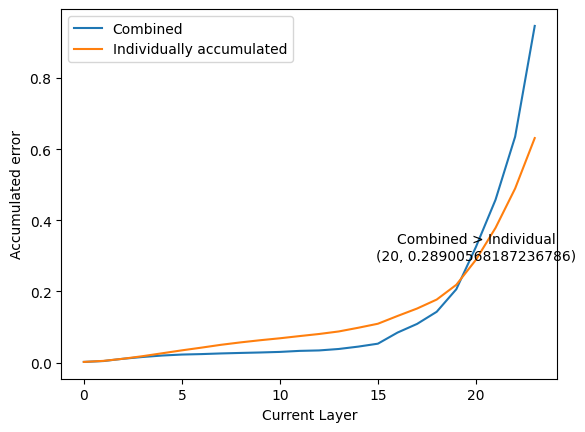

In [13]:
import matplotlib.pyplot as plt
import numpy as np

y1 =accum_list
y2 = [sum(individually_list[:i+1]) for i in range(len(individually_list))]

diffx,diffy =0,0
for idx, combined, individual in zip(range(len(y1)), y1, y2):
    if combined > individual*1.01:
        diffx = idx
        diffy = individual
        break
plt.plot(y1, label='Combined')
plt.plot(y2, label='Individually accumulated')
plt.text(diffx, diffy, f"Combined > Individual\n({diffx}, {diffy})", fontsize=10, ha='center')

plt.xlabel('Current Layer')
plt.ylabel('Accumulated error')
plt.legend()
plt.show()